In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

## Time Series Components
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

**Systematic**: Components of the time series that have consistency or recurrence and can be described and modeled. <br>
**Non-Systematic**: Components of the time series that cannot be directly modeled. <br>
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

**Cyclic and seasonal time series**

A **seasonal pattern** exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period. Hence, seasonal time series are sometimes called periodic time series.

A **cyclic pattern** exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually of at least 2 years. Think of business cycles which usually last several years, but where the length of the current cycle is unknown beforehand.

## Hodrick-Prescott Filter: to get the trend

The Hodrick-Prescott filter separates a time-series  $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$

$y_t = \tau_t + c_t$

The components are determined by minimizing the following quadratic loss function, where $\lambda$ is a smoothing parameter:

$\min_{\\{ \tau_{t}\\} }\sum_{t=1}^{T}c_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$


The $\lambda$ value above handles variations in the growth rate of the trend component.<br>When analyzing quarterly data, the default lambda value of 1600 is recommended. Use 6.25 for annual data, and 129,600 for monthly data.

In [3]:
import statsmodels.api as sm

df = sm.datasets.macrodata.load_pandas().data
df.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))

print('Data Description', sm.datasets.macrodata.NOTE)

df.head()

Data Description ::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


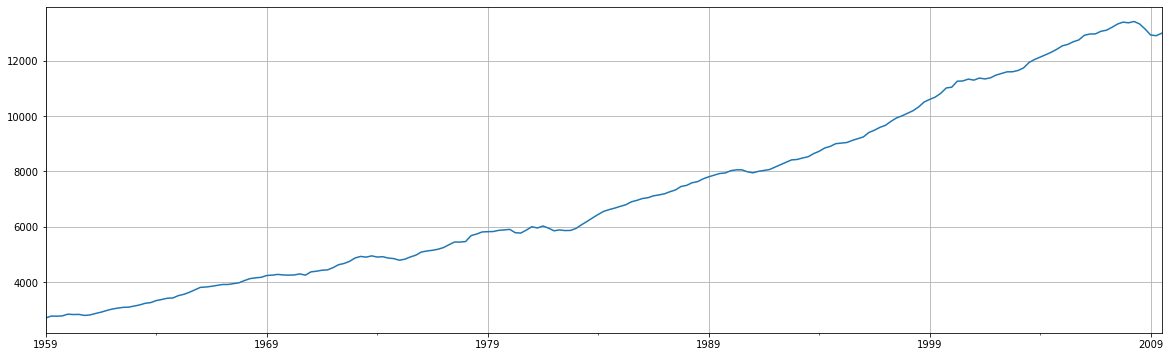

In [4]:
df['realgdp'].plot();

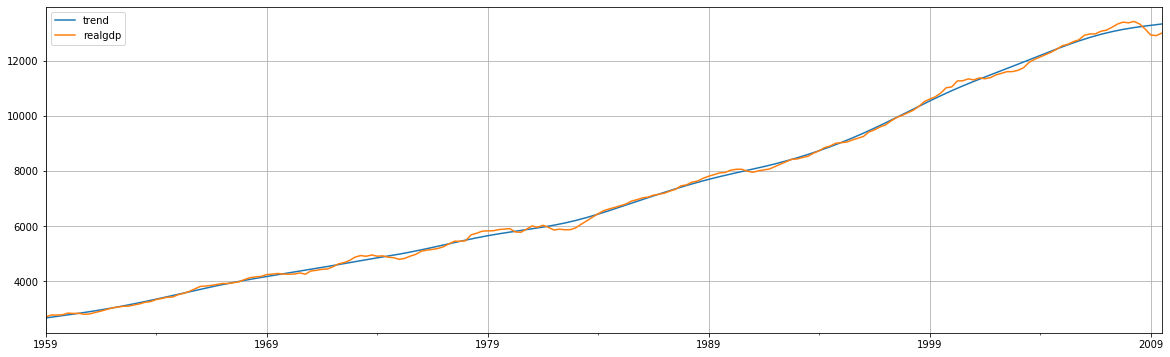

In [5]:
from statsmodels.tsa.filters.hp_filter import hpfilter

gdp_cycle, gdp_trend = hpfilter(df['realgdp'], lamb=1600)
df['trend'] = gdp_trend
df[['trend','realgdp']].plot();

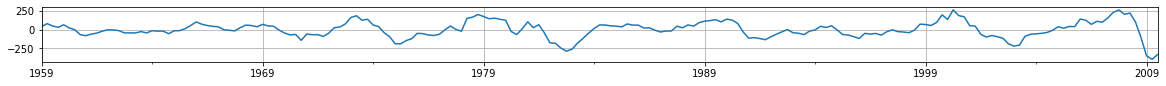

In [6]:
gdp_cycle.plot(figsize=(20,1));

## Error/Trend/Seasonality Models
As we begin working with **endogenous** data ("endog" for short) and start to develop forecasting models, it helps to identify and isolate factors working within the system that influence behavior. Here the name "endogenous" considers internal factors, while "exogenous" would relate to external forces. These fall under the category of **state space models**, and include **decomposition** (described below), and **exponential smoothing** (described in an upcoming section).

The decomposition of a time series attempts to isolate individual components such as **error**, **trend**, and **seasonality** (ETS).

Statsmodels provides a **seasonal decomposition** tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.

We apply an **additive** model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).

A **multiplicative** model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).

For these examples we'll use the International Airline Passengers dataset, which gives monthly totals in thousands from January 1949 to December 1960.

In [7]:
airline = pd.read_csv('../meta/airline_passengers.csv',index_col='Month',parse_dates=True)
airline.dropna(inplace=True)
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


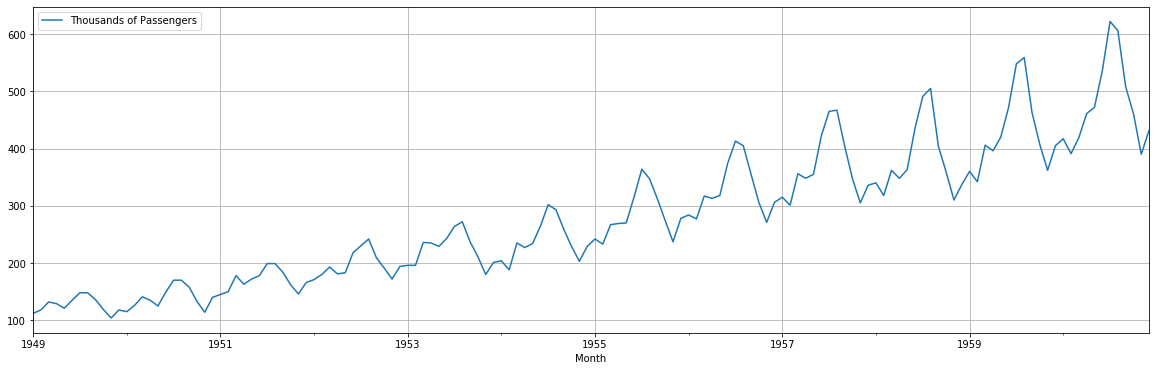

In [8]:
airline.plot();

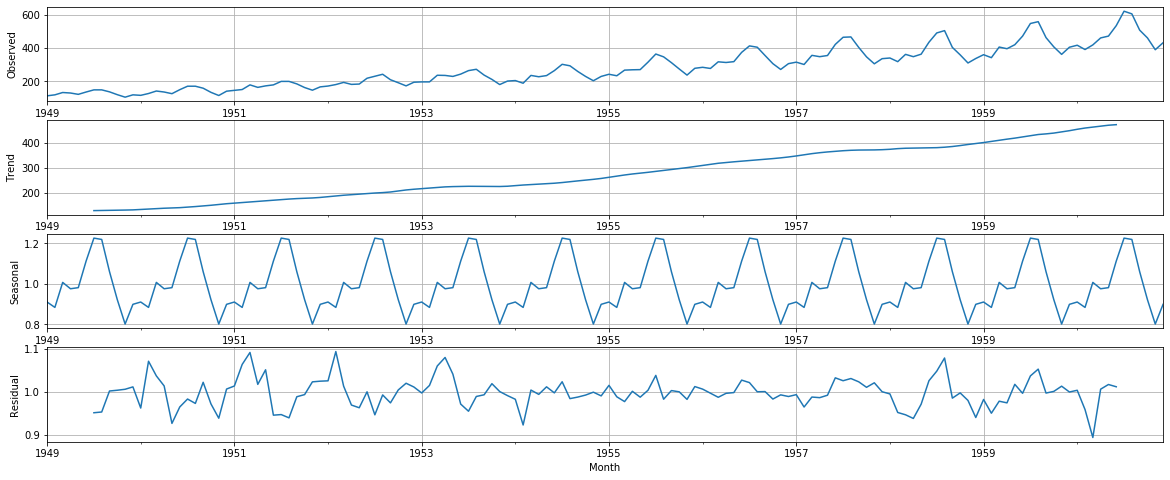

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(4, 1, figsize=(20, 8))
result = seasonal_decompose(airline['Thousands of Passengers'], model='multiplicative')

result.observed.plot(ax=ax[0]); ax[0].set_ylabel('Observed');
result.trend.plot(ax=ax[1]);    ax[1].set_ylabel('Trend');
result.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('Seasonal');
result.resid.plot(ax=ax[3]);    ax[3].set_ylabel('Residual');

## Exponentially Weighted Moving Average

**Simple Moving Average**

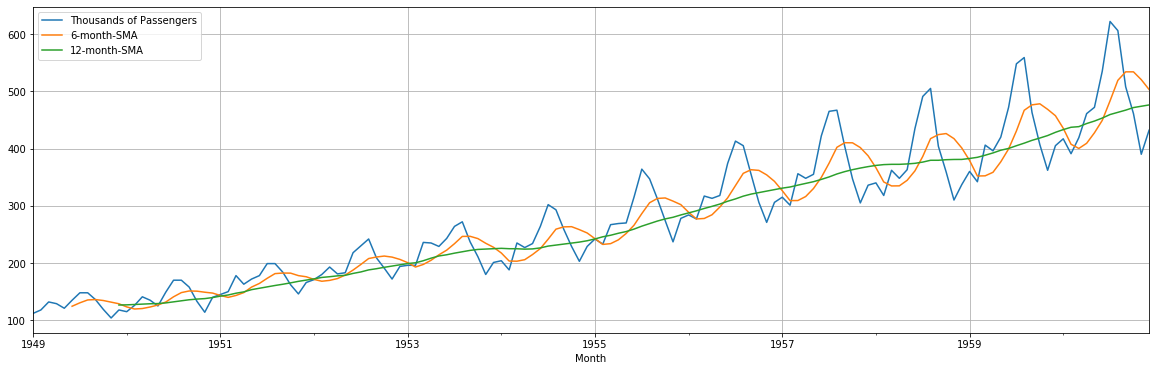

In [10]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()
airline.plot();

**Exponentially Weighted Moving Average**

Basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an EWMA (Exponentially weighted moving average).

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.

The formula for EWMA is:<center>
 $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$
 </center>
 Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the `adjust` parameter you provide to the `.ewm()` method.

When `adjust=True` (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives
<center>
$y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$
</center>
When `adjust=False` is specified, moving averages are calculated as:
<center>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$
</center>
which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When `adjust=True` we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}
 
* **Span** corresponds to what is commonly called an “N-day EW moving average”.
* **Center of mass** has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* **Half-life** is the period of time for the exponential weight to reduce to one half.
* **Alpha** specifies the smoothing factor directly.

We have to pass precisely one of the above into the `.ewm()` function. For our data we'll use `span=12`.

Reference: [Pandas Documentation](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows)

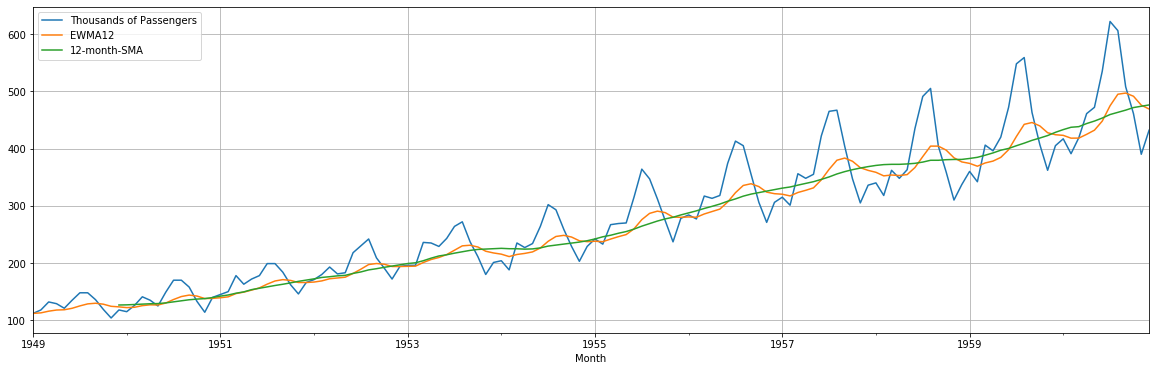

In [11]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()
airline[['Thousands of Passengers','EWMA12','12-month-SMA']].plot();

## Holt-Winters Methods
Using Exponentially Weighted Moving Averages (EWMA) we applied **Simple Exponential Smoothing** using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

Holt (1957) and Winters (1960) extended Holt’s method to capture seasonality. The Holt-Winters seasonal method comprises of the forecast equation and three smoothing equations.

One for the level ℓ_t , one for the trend b_t , and one for the seasonal component s_t , with corresponding smoothing parameters α , β and γ .

There are two variations to this method that differ in the nature of the seasonal component.
* The additive method is preferred when the seasonal variations are roughly constant through the series,
* The multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.


Therefore we'll look at **Double** and **Triple Exponential Smoothing** with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In **Double Exponential Smoothing** (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With **Triple Exponential Smoothing** (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

**Setting a DatetimeIndex Frequency**
Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.

In [12]:
airline.index.freq = 'MS'

**Simple Exponential Smoothing**

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
<center>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$
</center>

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

airline['SES12']=SimpleExpSmoothing(airline['Thousands of Passengers']).fit(
    smoothing_level=alpha,optimized=False
).fittedvalues.shift(-1)
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12
Month,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000
1949-02-01,118,NaN,NaN,112.923077,112.923077
1949-03-01,132,NaN,NaN,115.857988,115.857988
1949-04-01,129,NaN,NaN,117.879836,117.879836
1949-05-01,121,NaN,NaN,118.359861,118.359861


**NOTE:** For some reason, when `optimized=False` is passed into `.fit()`, the statsmodels `SimpleExpSmoothing` function shifts fitted values down one row. We fix this by adding `.shift(-1)` after `.fittedvalues`

**Double Exponential Smoothing**

Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

airline['DESadd12'] = ExponentialSmoothing(airline['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12
Month,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.237772
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.237772
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.237772
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.237772
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.237772


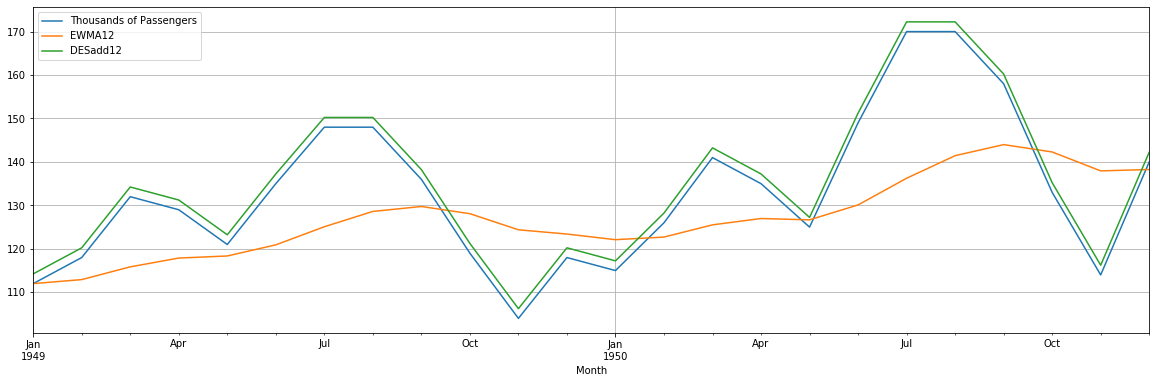

In [15]:
airline[['Thousands of Passengers','EWMA12','DESadd12']][:24].plot();

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.<br>
Let's see if using a multiplicative seasonal adjustment helps.

In [16]:
airline['DESmul12'] = ExponentialSmoothing(airline['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.237772,112.049247
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.237772,118.051885
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.237772,132.058041
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.237772,129.056722
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.237772,121.053204


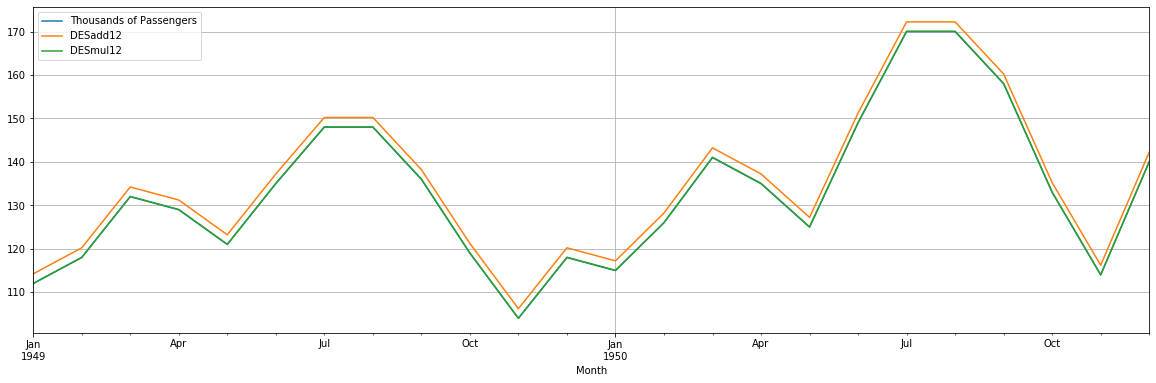

In [17]:
airline[['Thousands of Passengers','DESadd12','DESmul12']][:24].plot();

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

**Triple Exponential Smoothing**

Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 

In [18]:
airline['TESadd12'] = ExponentialSmoothing(
    airline['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12
).fit().fittedvalues
airline.head()

D:\Users\Ritvik\Anaconda3\envs\ailab\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.237772,112.049247,113.081288
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.237772,118.051885,120.550753
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.237772,132.058041,135.527339
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.237772,129.056722,133.155076
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.237772,121.053204,125.656129


In [19]:
airline['TESmul12'] = ExponentialSmoothing(
    airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12
).fit().fittedvalues
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.237772,112.049247,113.081288,111.608110
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.237772,118.051885,120.550753,118.853687
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.237772,132.058041,135.527339,133.343675
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.237772,129.056722,133.155076,127.912641
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.237772,121.053204,125.656129,120.991626


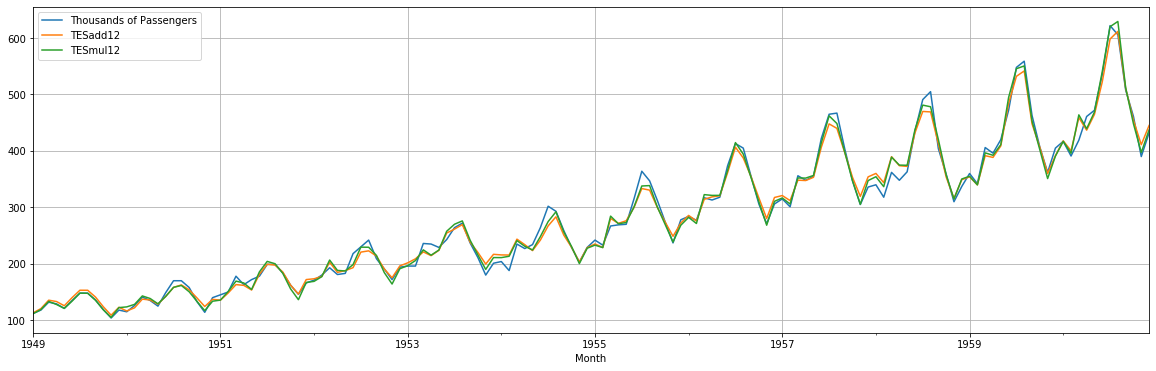

In [20]:
airline[['Thousands of Passengers','TESadd12','TESmul12']].plot();

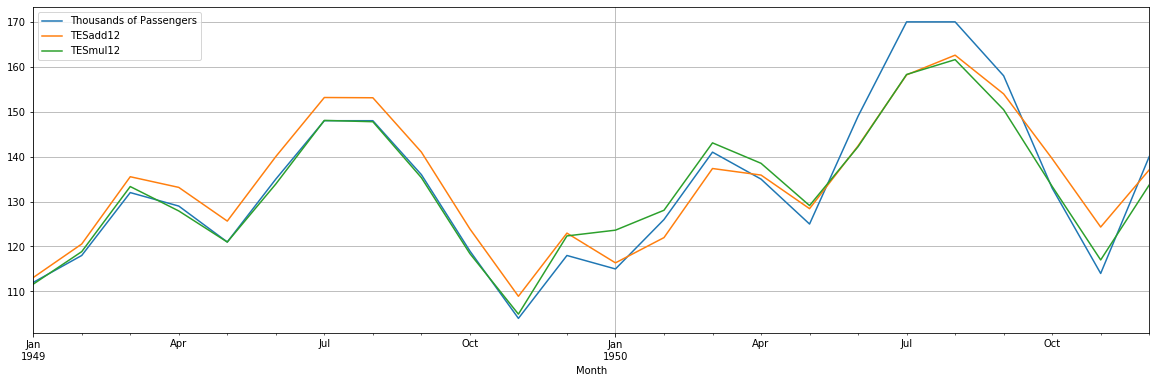

In [21]:
airline[['Thousands of Passengers','TESadd12','TESmul12']][:24].plot();

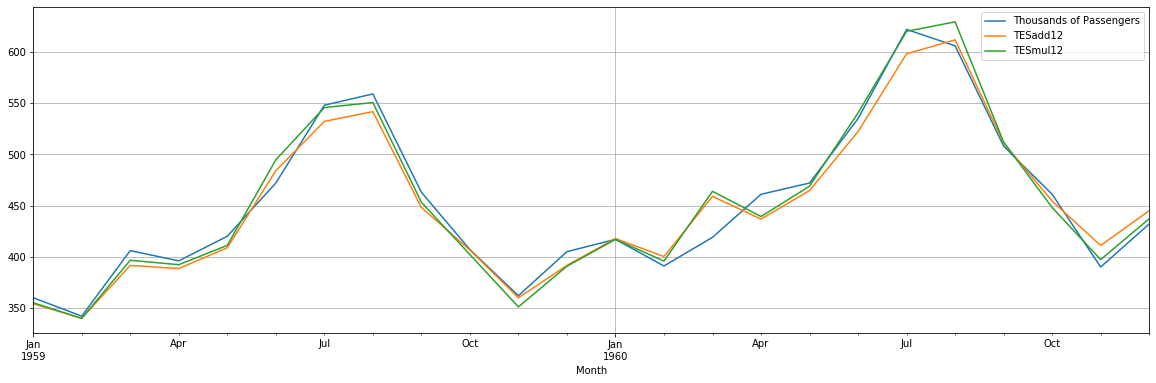

In [22]:
airline[['Thousands of Passengers','TESadd12','TESmul12']][-24:].plot();